Cell-1

In [ ]:
!pip install --quiet opencv-python-headless tensorflow scikit-learn matplotlib

Cell-2

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

def preprocess_image(img, target_size=(224, 224)):
    # Resize
    img = cv2.resize(img, target_size)

    # LAB + CLAHE (contrast enhancement - good for defect detection)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.8, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # Denoising
    denoised = cv2.bilateralFilter(enhanced, d=9, sigmaColor=75, sigmaSpace=75)

    # Sharpening
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(denoised, -1, kernel)

    # Convert BGR → RGB (VGG expects RGB)
    sharpened_rgb = cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB)

    # Apply VGG16-specific preprocessing
    preprocessed = preprocess_input(sharpened_rgb.astype(np.float32))

    return preprocessed

Cell-3

In [ ]:
def load_dataset(data_dir="/content/dataset", img_size=(224, 224)):
    images = []
    labels = []
    class_names = ['crack', 'corrosion', 'normal']
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        folder = os.path.join(data_dir, class_name)
        print(f"Loading {class_name}...")
        if not os.path.exists(folder):
            print(f"  → Folder not found: {folder}")
            continue

        for filename in os.listdir(folder):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                path = os.path.join(folder, filename)
                img = cv2.imread(path)
                if img is not None:
                    processed = preprocess_image(img, img_size)
                    images.append(processed)
                    labels.append(class_to_idx[class_name])
                else:
                    print(f"  Failed to load: {filename}")

    print(f"\nLoaded total: {len(images)} images")
    if len(images) > 0:
        print("Class distribution:", dict(zip(class_names, np.bincount(labels))))

    return np.array(images), np.array(labels)

Cell-4

In [ ]:
def create_model(input_shape=(224, 224, 3)):
    # Load pre-trained VGG16 (ImageNet weights) without top classifier
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the convolutional base initially
    base_model.trainable = False

    model = models.Sequential([
        base_model,

        layers.GlobalAveragePooling2D(),

        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(3, activation='softmax', name='output')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print("Model created (VGG16 base frozen)")
    model.summary()
    return model

Cell-5

In [ ]:
from google.colab import files
print("Please upload your dataset.zip file")
uploaded = files.upload()

Please upload your dataset.zip file


Saving dataset.zip to dataset.zip


Cell-6

In [ ]:
!unzip -q dataset.zip -d /content/
print("Dataset unzipped to /content/dataset")
!ls /content/dataset

Dataset unzipped to /content/dataset
corrosion  crack  normal


Cell-7

Loading crack...
Loading corrosion...
  Failed to load: wreck-passenger-ship-salem-express-bottom-red-sea-egypt-wreck-passenger-ship-salem-express-covered-coral-134901344_jpg.rf.b45280a4f1bac74fc869bdaf606af535.jpg
Loading normal...

Loaded total: 354 images
Class distribution: {'crack': np.int64(121), 'corrosion': np.int64(113), 'normal': np.int64(120)}

Training samples   : 283
Validation samples : 71
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created (VGG16 base frozen)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,515 (57.65 MB)

 Trainable params: 396,291 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)


Starting training...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6257 - loss: 1.0700 - val_accuracy: 0.7183 - val_loss: 1.2725
Epoch 2/40
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8750 - loss: 0.2138

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8750 - loss: 0.2138 - val_accuracy: 0.7183 - val_loss: 1.1736
Epoch 3/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.9463 - loss: 0.1210 - val_accuracy: 0.9014 - val_loss: 0.4091
Epoch 4/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9437 - val_loss: 0.3971
Epoch 5/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.9710 - loss: 0.0943 - val_accuracy: 0.9437 - val_loss: 0.1933
Epoch 6/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0745 - val_accuracy: 0.9437 - val_loss: 0.1856
Epoch 7/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.9723 - loss: 0.0573 - val_accuracy: 0.9718 - val_loss: 0.1184
Epoch 8/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.9718 - val_loss: 0.1205
Epoch 9/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.9432 - loss: 0.1548 - val_accuracy: 0.9718 - val_loss


Model saved → /content/pipe_defect_vgg16_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


FINAL TRAINING RESULTS (VGG16 Transfer Learning)
Training Accuracy    : 100.00%
Validation Accuracy  : 97.18%
Training Loss        : 0.0104
Validation Loss      : 0.0337

Best Validation Accuracy : 98.59% (at epoch 11)



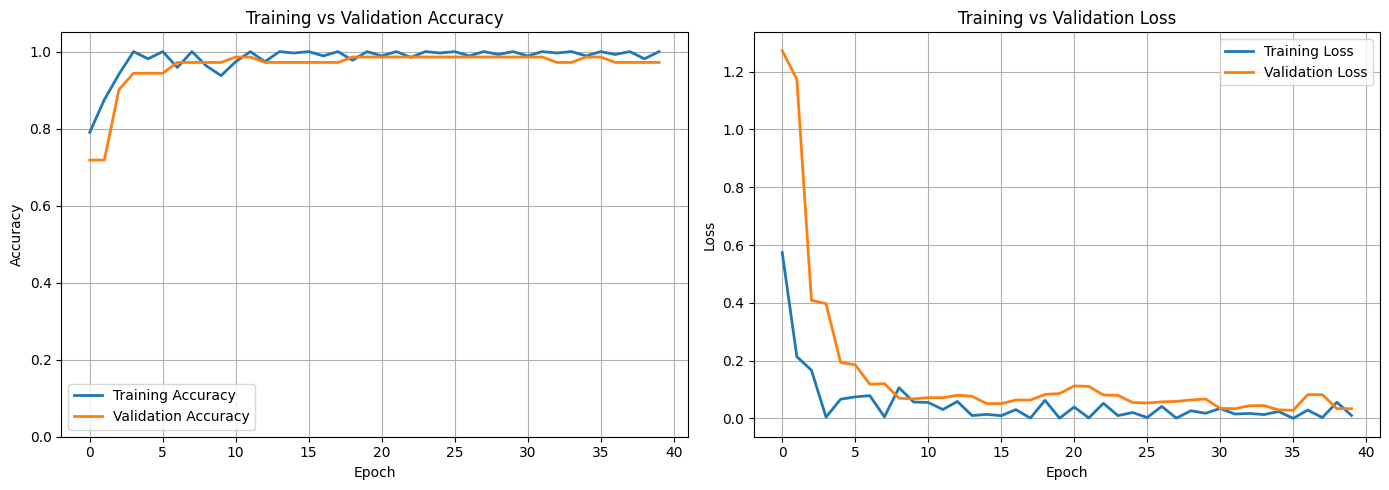

In [ ]:
# Load and prepare data
X, y = load_dataset(data_dir="/content/dataset")

if len(X) == 0:
    print("ERROR: No images were loaded. Please check your dataset folder structure.")
else:
    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )

    print(f"\nTraining samples   : {len(X_train)}")
    print(f"Validation samples : {len(X_val)}")

    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
        # No rescale needed — already preprocessed with vgg16.preprocess_input
    )

    # Create and train model
    model = create_model()

    print("\nStarting training...\n")

    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=16),
        validation_data=(X_val, y_val),
        epochs=40,
        steps_per_epoch=len(X_train) // 16,
        verbose=1
    )

    # Save model
    model.save("/content/pipe_defect_vgg16_model.h5")
    print("\nModel saved → /content/pipe_defect_vgg16_model.h5")

    # Auto-download
    from google.colab import files
    files.download("/content/pipe_defect_vgg16_model.h5")

    # ───── FINAL RESULTS ─────
    final_train_acc = history.history['accuracy'][-1] * 100
    final_val_acc   = history.history['val_accuracy'][-1] * 100
    final_train_loss = history.history['loss'][-1]
    final_val_loss   = history.history['val_loss'][-1]

    print("\n" + "="*70)
    print("FINAL TRAINING RESULTS (VGG16 Transfer Learning)")
    print("="*70)
    print(f"Training Accuracy    : {final_train_acc:.2f}%")
    print(f"Validation Accuracy  : {final_val_acc:.2f}%")
    print(f"Training Loss        : {final_train_loss:.4f}")
    print(f"Validation Loss      : {final_val_loss:.4f}")

    best_val_acc = max(history.history['val_accuracy']) * 100
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    print(f"\nBest Validation Accuracy : {best_val_acc:.2f}% (at epoch {best_epoch})")
    print("="*70 + "\n")

    # ───── PLOTS ─────
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.05)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Cell-8

Upload an image of a pipe to classify...


Saving 035.png to 035.png

Processing: 035.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step

PREDICTION: NORMAL
Confidence: 100.00%

Probabilities:
  crack      : 0.00%
  corrosion  : 0.00%
  normal     : 100.00%


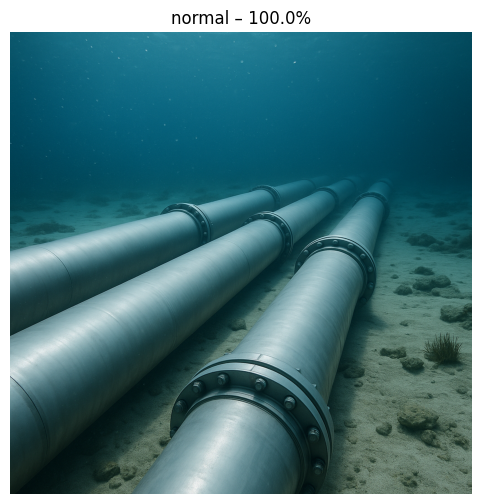

In [ ]:
from google.colab import files
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("/content/pipe_defect_vgg16_model.h5")

print("Upload an image of a pipe to classify...")
uploaded = files.upload()

if uploaded:
    filename = list(uploaded.keys())[0]
    print(f"\nProcessing: {filename}")

    img = cv2.imread(filename)
    if img is None:
        print("Error: Could not read the image.")
    else:
        # Preprocess (same as training)
        processed = preprocess_image(img)

        # Predict
        pred = model.predict(np.expand_dims(processed, axis=0))[0]

        classes = ['crack', 'corrosion', 'normal']
        predicted_class = classes[np.argmax(pred)]
        confidence = pred.max() * 100

        print("\n" + "="*60)
        print(f"PREDICTION: {predicted_class.upper()}")
        print(f"Confidence: {confidence:.2f}%")
        print("="*60)

        print("\nProbabilities:")
        for c, p in zip(classes, pred):
            print(f"  {c:10} : {p*100:.2f}%")

        # Display image
        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"{predicted_class} – {confidence:.1f}%")
        plt.axis('off')
        plt.show()